# 03 - Model Evaluation: Checkpoint Analysis

**Objective**: Load and analyze the trained Legal-Longformer checkpoint.

This notebook evaluates the model saved during training, examining:
- Overall metrics (F1, Precision, Recall)
- Per-class performance
- Confusion analysis
- Comparison with TF-IDF baseline

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import DataLoader
from src.model_trainer import DataPreparer
from src.model_evaluator import MultiLabelEvaluator
from src.bert_trainer import (
    DeviceManager, 
    HybridLegalClassifier,
    LegalLongformerTrainer,
)

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

## 1. Load Data and Checkpoint

In [2]:
# Load data (same as training)
loader = DataLoader('../data/TRDataChallenge2023.txt')
preparer = DataPreparer(loader, min_label_count=50, random_state=42)
data = preparer.prepare(max_features=10000, ngram_range=(1, 2))

print(data.summary())
print(f"\nLabels: {len(data.label_names)}")

PREPARED DATA SUMMARY
Train samples:     11,708
Validation samples:2,509
Test samples:      2,510
Number of labels:  41
Feature dimension: 10000

Labels: 41


In [3]:
# Check available model files
import json

model_path = Path('../outputs/legal_longformer_best.pt')
history_path = Path('../outputs/legal_longformer_best.history.json')

print("Model files:")
history = None

if model_path.exists():
    size_mb = model_path.stat().st_size / 1e6
    print(f"  {model_path.name}: {size_mb:.1f} MB ✓")
else:
    print(f"  {model_path.name}: NOT FOUND ❌")

if history_path.exists():
    print(f"  {history_path.name} ✓")
    with open(history_path) as f:
        history = json.load(f)
    print(f"\nTraining History:")
    print(f"  Best F1:    {history['best_f1']:.4f}")
    print(f"  Best epoch: {history['best_epoch']}")
else:
    print(f"  {history_path.name}: NOT FOUND")

Model files:
  legal_longformer_best.pt: 594.1 MB ✓
  legal_longformer_best.history.json ✓

Training History:
  Best F1:    0.6277
  Best epoch: 4


In [4]:
# Show training history (from saved JSON)
if history:
    print("Training progression:")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Val F1 Micro':<14} {'Val F1 Macro':<14}")
    print("-" * 60)
    for i in range(len(history['train_losses'])):
        best_marker = " ← best" if (i + 1) == history['best_epoch'] else ""
        print(f"{i+1:<8} {history['train_losses'][i]:<12.4f} {history['val_losses'][i]:<12.4f} "
              f"{history['val_f1_micro'][i]:<14.4f} {history['val_f1_macro'][i]:<14.4f}{best_marker}")
else:
    print("No training history available")

Training progression:
Epoch    Train Loss   Val Loss     Val F1 Micro   Val F1 Macro  
------------------------------------------------------------
1        0.9361       0.8230       0.3962         0.0937        
2        0.6795       0.5392       0.4542         0.2342        
3        0.4873       0.4258       0.5453         0.3394        
4        0.3915       0.3851       0.6277         0.4168         ← best
5        0.3318       0.3527       0.6236         0.4129        


## 2. Load Model from Checkpoint

In [5]:
# Initialize hybrid classifier and load best model
hybrid_classifier = HybridLegalClassifier(
    num_labels=len(data.label_names),
    cache_dir='../outputs/summaries',
    device='auto',
)

# Load the best model (saved after training completed)
hybrid_classifier.load('../outputs/legal_longformer_best.pt')

if history:
    best_epoch = history['best_epoch']
    print(f"✓ Loaded best model (epoch {best_epoch})")
    print(f"  Val F1 Micro: {history['val_f1_micro'][best_epoch-1]:.4f}")
    print(f"  Val F1 Macro: {history['val_f1_macro'][best_epoch-1]:.4f}")
else:
    print("✓ Loaded model from legal_longformer_best.pt")

INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
INFO:src.bert_trainer:Loading classification model: lexlms/legal-longformer-base
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:src.bert_trainer:Model loaded with 41 labels
INFO:src.bert_trainer:Model loaded from ../outputs/legal_longformer_best.pt


✓ Loaded best model (epoch 4)
  Val F1 Micro: 0.6277
  Val F1 Macro: 0.4168


## 3. Preprocess Test Data

In [6]:
# Preprocess test texts (uses cached summaries)
print("Preprocessing test texts...")
test_texts_processed = hybrid_classifier.preprocess_texts(data.test_texts)

stats = hybrid_classifier.get_processing_stats()
print(f"\nProcessed: {stats['total_processed']}")
print(f"Direct: {stats['direct_classified']}")
print(f"Summarized: {stats['summarized_first']}")

Preprocessing test texts...


Token indices sequence length is longer than the specified maximum sequence length for this model (4535 > 4096). Running this sequence through the model will result in indexing errors
INFO:src.bert_trainer:Summarizing 848 long documents (batch_size=8)...
INFO:src.bert_trainer:Loading summarization model: nsi319/legal-led-base-16384
INFO:src.bert_trainer:Summarization model loaded successfully
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



Processed: 2510
Direct: 1662
Summarized: 848


## 4. Generate Predictions

In [7]:
# Get predictions and probabilities
print("Generating predictions...")
y_proba = hybrid_classifier.predict_proba(test_texts_processed, preprocess=False, batch_size=16)
y_pred = (y_proba >= 0.5).astype(int)

print(f"Predictions shape: {y_pred.shape}")
print(f"Positive predictions per sample: {y_pred.sum(axis=1).mean():.2f} avg")

Generating predictions...


Predicting:   0%|          | 0/157 [00:00<?, ?it/s]

Initializing global attention on CLS token...


Predictions shape: (2510, 41)
Positive predictions per sample: 3.05 avg


## 5. Overall Evaluation

In [8]:
# Evaluate
evaluator = MultiLabelEvaluator(data.label_names)
results = evaluator.evaluate(data.y_test, y_pred)

print(results.summary())

MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.6220
  F1 Macro:          0.4362
  F1 Weighted:       0.7126
  F1 Samples:        0.6655

  Precision (micro): 0.4709
  Precision (macro): 0.3404
  Recall (micro):    0.9160
  Recall (macro):    0.7629

  Hamming Loss:      0.0426
  Exact Match Ratio: 0.2649


## 6. Per-Class Performance

In [9]:
# Top performing classes
print("TOP 10 CLASSES (by F1):")
results.get_top_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

TOP 10 CLASSES (by F1):


,label,precision,recall,f1,support
1,Appellate Review,0.933803,0.962264,0.947820,689
0,On Appeal,0.771380,0.968504,0.858775,1397
38,Motion to Disqualify Counsel,0.750000,1.000000,0.857143,6
2,Review of Administrative Decision,0.608347,0.957071,0.743867,396
19,Juvenile Delinquency Proceeding,0.714286,0.750000,0.731707,20
12,Motion to Compel Arbitration,0.588235,0.909091,0.714286,33
24,Motion for Sanctions (Discovery),0.611111,0.733333,0.666667,15
22,Motion for Contempt,0.472222,1.000000,0.641509,17
6,Motion for Attorney's Fees,0.502732,0.828829,0.625850,111
33,Certified Question,1.000000,0.444444,0.615385,9


In [10]:
# Bottom performing classes
print("BOTTOM 10 CLASSES (by F1):")
results.get_bottom_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

BOTTOM 10 CLASSES (by F1):


,label,precision,recall,f1,support
34,Motion for Permanent Injunction,0.045045,0.555556,0.083333,9
21,Motion to Dismiss for Lack of Jurisdiction,0.051020,0.526316,0.093023,19
16,Motion for Reconsideration,0.069519,0.481481,0.121495,27
27,Petition for Custody,0.111111,0.166667,0.133333,12
26,Motion to Set Aside or Vacate,0.108696,0.384615,0.169492,13
40,Motion for Restraining or Protection Order,0.103448,0.750000,0.181818,4
31,Motion to Stay Proceedings,0.121951,0.500000,0.196078,10
9,Motion to Dismiss for Lack of Subject Matter J...,0.126074,0.916667,0.221662,48
25,Motion to Transfer or Change Venue,0.148148,0.615385,0.238806,13
7,Post-Trial Hearing Motion,0.154195,0.860759,0.261538,79


In [12]:
# Full per-class metrics
per_class = results.per_class_metrics.copy()
per_class = per_class.sort_values('f1', ascending=False)
per_class

,label,precision,recall,f1,support,predicted_count
1,Appellate Review,0.933803,0.962264,0.947820,689,710
0,On Appeal,0.771380,0.968504,0.858775,1397,1754
38,Motion to Disqualify Counsel,0.750000,1.000000,0.857143,6,8
2,Review of Administrative Decision,0.608347,0.957071,0.743867,396,623
19,Juvenile Delinquency Proceeding,0.714286,0.750000,0.731707,20,21
12,Motion to Compel Arbitration,0.588235,0.909091,0.714286,33,51
24,Motion for Sanctions (Discovery),0.611111,0.733333,0.666667,15,18
22,Motion for Contempt,0.472222,1.000000,0.641509,17,36
6,Motion for Attorney's Fees,0.502732,0.828829,0.625850,111,183
33,Certified Question,1.000000,0.444444,0.615385,9,4


## 7. F1 Distribution by Class

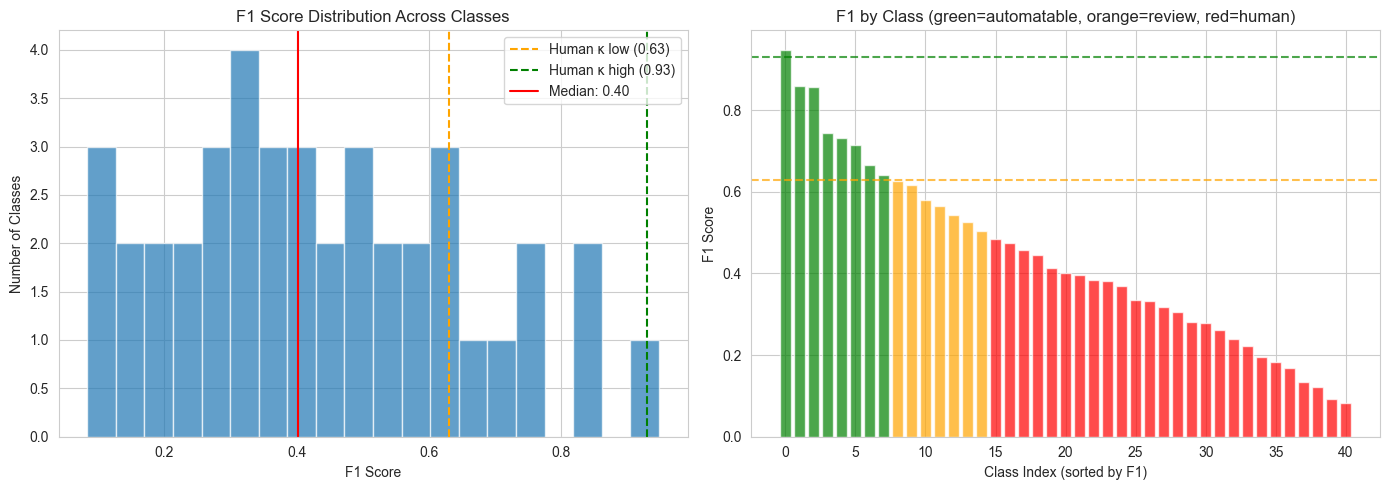

In [13]:
# F1 distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(per_class['f1'], bins=20, edgecolor='white', alpha=0.7)
ax1.axvline(x=0.63, color='orange', linestyle='--', label='Human κ low (0.63)')
ax1.axvline(x=0.93, color='green', linestyle='--', label='Human κ high (0.93)')
ax1.axvline(x=per_class['f1'].median(), color='red', linestyle='-', label=f'Median: {per_class["f1"].median():.2f}')
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Number of Classes')
ax1.set_title('F1 Score Distribution Across Classes')
ax1.legend()

# Bar chart by class
ax2 = axes[1]
colors = ['green' if f1 >= 0.63 else 'orange' if f1 >= 0.5 else 'red' for f1 in per_class['f1']]
ax2.bar(range(len(per_class)), per_class['f1'], color=colors, alpha=0.7)
ax2.axhline(y=0.63, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(y=0.93, color='green', linestyle='--', alpha=0.7)
ax2.set_xlabel('Class Index (sorted by F1)')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 by Class (green=automatable, orange=review, red=human)')

plt.tight_layout()
plt.show()

## 8. Threshold Analysis

In [20]:
# Try different thresholds
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
thresh_results = []

for thresh in thresholds:
    y_pred_t = (y_proba >= thresh).astype(int)
    thresh_results.append({
        'threshold': thresh,
        'f1_micro': f1_score(data.y_test, y_pred_t, average='micro', zero_division=0),
        'f1_macro': f1_score(data.y_test, y_pred_t, average='macro', zero_division=0),
        'precision': precision_score(data.y_test, y_pred_t, average='micro', zero_division=0),
        'recall': recall_score(data.y_test, y_pred_t, average='micro', zero_division=0),
        'avg_preds': y_pred_t.sum(axis=1).mean(),
    })

thresh_df = pd.DataFrame(thresh_results)
thresh_df

,threshold,f1_micro,f1_macro,precision,recall,avg_preds
0,0.1,0.134366,0.081711,0.072033,0.997716,21.741833
1,0.2,0.274717,0.149018,0.159798,0.978173,9.608765
2,0.3,0.411605,0.246045,0.261855,0.961421,5.763347
3,0.4,0.529588,0.349656,0.368583,0.940355,4.004781
4,0.5,0.622027,0.436151,0.470903,0.915990,3.053386
5,0.6,0.685354,0.505856,0.571283,0.856345,2.352988
6,0.7,0.684767,0.516944,0.650091,0.723350,1.746614
7,0.8,0.580811,0.434183,0.719265,0.487056,1.062948


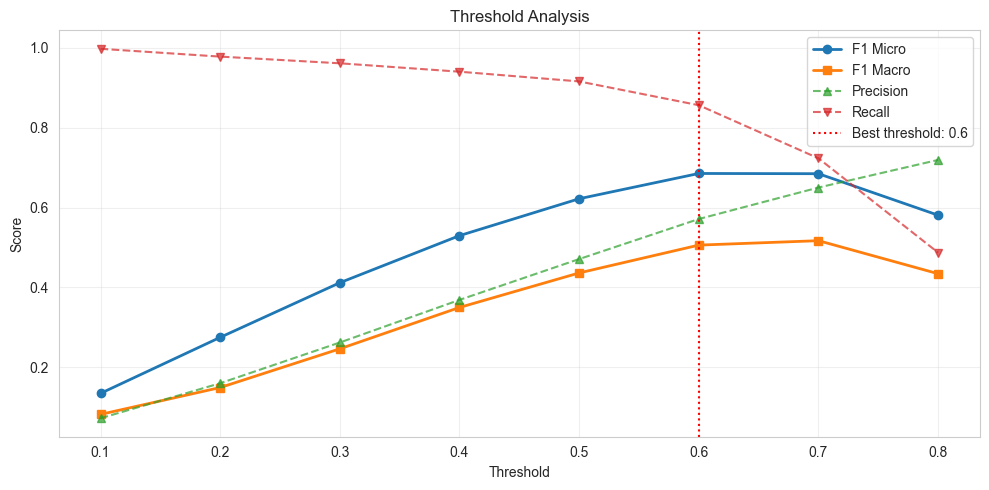


Best threshold: 0.6 → F1 Micro: 0.6854


In [15]:
# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresh_df['threshold'], thresh_df['f1_micro'], 'o-', label='F1 Micro', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['f1_macro'], 's-', label='F1 Macro', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['precision'], '^--', label='Precision', alpha=0.7)
ax.plot(thresh_df['threshold'], thresh_df['recall'], 'v--', label='Recall', alpha=0.7)

best_thresh = thresh_df.loc[thresh_df['f1_micro'].idxmax(), 'threshold']
ax.axvline(x=best_thresh, color='red', linestyle=':', label=f'Best threshold: {best_thresh}')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Analysis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest threshold: {best_thresh} → F1 Micro: {thresh_df.loc[thresh_df['f1_micro'].idxmax(), 'f1_micro']:.4f}")

In [22]:
# Evaluate with optimal threshold (0.6)
OPTIMAL_THRESHOLD = 0.6

y_pred_optimal = (y_proba >= OPTIMAL_THRESHOLD).astype(int)
results_optimal = evaluator.evaluate(data.y_test, y_pred_optimal)

print(f"=== Results with Optimal Threshold ({OPTIMAL_THRESHOLD}) ===")
print(results_optimal.summary())

print(f"\nImprovement over default (0.5):")
print(f"  F1 Micro: {results.f1_micro:.4f} → {results_optimal.f1_micro:.4f} ({(results_optimal.f1_micro - results.f1_micro)*100:+.1f}%)")
print(f"  F1 Macro: {results.f1_macro:.4f} → {results_optimal.f1_macro:.4f} ({(results_optimal.f1_macro - results.f1_macro)*100:+.1f}%)")

=== Results with Optimal Threshold (0.6) ===
MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.6854
  F1 Macro:          0.5059
  F1 Weighted:       0.7464
  F1 Samples:        0.7146

  Precision (micro): 0.5713
  Precision (macro): 0.4398
  Recall (micro):    0.8563
  Recall (macro):    0.7094

  Hamming Loss:      0.0301
  Exact Match Ratio: 0.3510

Improvement over default (0.5):
  F1 Micro: 0.6220 → 0.6854 (+6.3%)
  F1 Macro: 0.4362 → 0.5059 (+7.0%)


In [23]:
# Per-class performance with optimal threshold
per_class_optimal = results_optimal.per_class_metrics

print(f"TOP 10 CLASSES (threshold={OPTIMAL_THRESHOLD}):")
display(per_class_optimal.nlargest(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

print(f"\nBOTTOM 10 CLASSES (threshold={OPTIMAL_THRESHOLD}):")
display(per_class_optimal.nsmallest(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

TOP 10 CLASSES (threshold=0.6):


,label,precision,recall,f1,support
1,Appellate Review,0.938920,0.959361,0.949031,689
38,Motion to Disqualify Counsel,0.857143,1.000000,0.923077,6
0,On Appeal,0.853166,0.877595,0.865208,1397
39,Application to Vacate Arbitration Award,0.714286,1.000000,0.833333,5
2,Review of Administrative Decision,0.748971,0.919192,0.825397,396
19,Juvenile Delinquency Proceeding,0.789474,0.750000,0.769231,20
12,Motion to Compel Arbitration,0.625000,0.909091,0.740741,33
6,Motion for Attorney's Fees,0.625899,0.783784,0.696000,111
22,Motion for Contempt,0.531250,1.000000,0.693878,17
30,Motion to Exclude Expert Report or Testimony,0.533333,0.800000,0.640000,10



BOTTOM 10 CLASSES (threshold=0.6):


,label,precision,recall,f1,support
34,Motion for Permanent Injunction,0.058824,0.555556,0.106383,9
21,Motion to Dismiss for Lack of Jurisdiction,0.064220,0.368421,0.109375,19
27,Petition for Custody,0.200000,0.166667,0.181818,12
40,Motion for Restraining or Protection Order,0.136364,0.750000,0.230769,4
16,Motion for Reconsideration,0.164384,0.444444,0.240000,27
26,Motion to Set Aside or Vacate,0.192308,0.384615,0.256410,13
31,Motion to Stay Proceedings,0.200000,0.400000,0.266667,10
14,Motion for Costs,0.171171,0.612903,0.267606,31
9,Motion to Dismiss for Lack of Subject Matter J...,0.164122,0.895833,0.277419,48
7,Post-Trial Hearing Motion,0.176301,0.772152,0.287059,79


## 9. Prediction Distribution Analysis

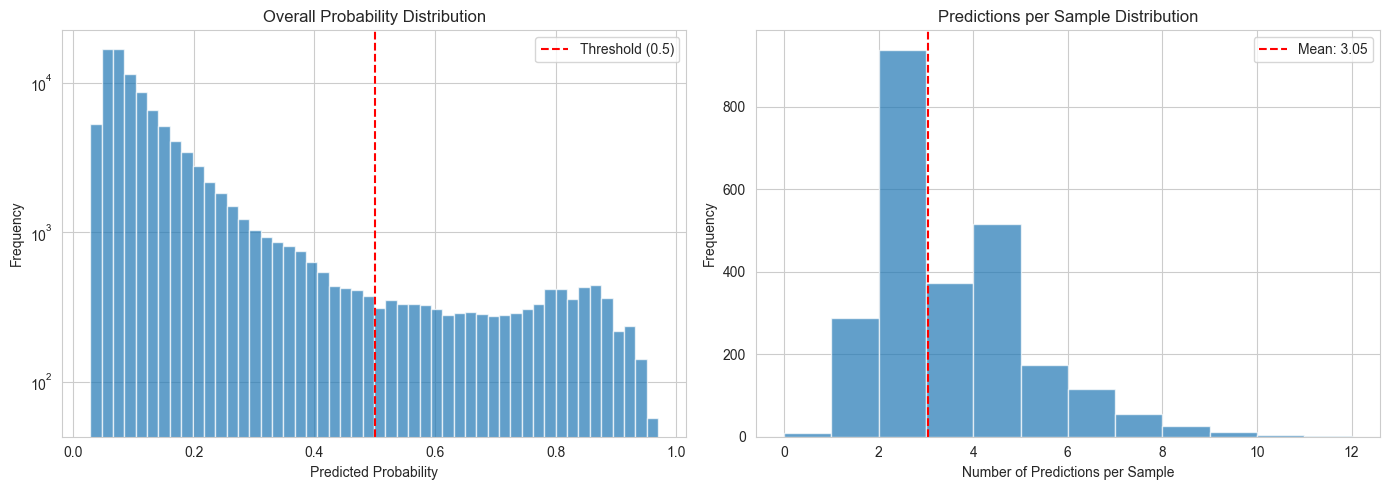

Samples with 0 predictions: 8 (0.3%)


In [24]:
# Analyze probability distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall probability distribution
ax1 = axes[0]
ax1.hist(y_proba.flatten(), bins=50, edgecolor='white', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Overall Probability Distribution')
ax1.legend()
ax1.set_yscale('log')

# Predictions per sample
ax2 = axes[1]
preds_per_sample = y_pred.sum(axis=1)
ax2.hist(preds_per_sample, bins=range(0, max(preds_per_sample)+2), edgecolor='white', alpha=0.7)
ax2.axvline(x=preds_per_sample.mean(), color='red', linestyle='--', label=f'Mean: {preds_per_sample.mean():.2f}')
ax2.set_xlabel('Number of Predictions per Sample')
ax2.set_ylabel('Frequency')
ax2.set_title('Predictions per Sample Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Samples with 0 predictions: {(preds_per_sample == 0).sum()} ({(preds_per_sample == 0).mean()*100:.1f}%)")

## 10. Feasibility Analysis

In [25]:
# Feasibility vs human annotator agreement
feasibility = results.get_feasibility_analysis(human_kappa_low=0.63, human_kappa_high=0.93)

print("=== AUTOMATION FEASIBILITY ===")
print(f"Fully automatable (F1 ≥ 0.63):  {feasibility['automation_feasible'].sum()} / {len(feasibility)}")
print(f"High confidence (F1 ≥ 0.93):    {feasibility['high_confidence'].sum()} / {len(feasibility)}")
print(f"Needs review (0.50 ≤ F1 < 0.63): {feasibility['needs_review'].sum()} / {len(feasibility)}")
print(f"Not feasible (F1 < 0.50):       {(~feasibility['automation_feasible'] & ~feasibility['needs_review']).sum()} / {len(feasibility)}")

=== AUTOMATION FEASIBILITY ===
Fully automatable (F1 ≥ 0.63):  8 / 41
High confidence (F1 ≥ 0.93):    1 / 41
Needs review (0.50 ≤ F1 < 0.63): 7 / 41
Not feasible (F1 < 0.50):       26 / 41


In [26]:
# Show automatable classes
print("\nCLASSES FEASIBLE FOR AUTOMATION:")
feasibility[feasibility['automation_feasible']][['label', 'f1', 'support']].sort_values('f1', ascending=False)


CLASSES FEASIBLE FOR AUTOMATION:


,label,f1,support
1,Appellate Review,0.947820,689
0,On Appeal,0.858775,1397
38,Motion to Disqualify Counsel,0.857143,6
2,Review of Administrative Decision,0.743867,396
19,Juvenile Delinquency Proceeding,0.731707,20
12,Motion to Compel Arbitration,0.714286,33
24,Motion for Sanctions (Discovery),0.666667,15
22,Motion for Contempt,0.641509,17


## 10. Per-Class Threshold Optimization

Find the optimal threshold for each class independently to maximize F1.

In [28]:
# Find optimal threshold for each class using validation set
# Note: We're using test set here (ideally use validation set to avoid data leakage)
from sklearn.metrics import f1_score

thresholds_to_try = np.arange(0.1, 0.95, 0.05)
optimal_thresholds = []

for class_idx in range(len(data.label_names)):
    best_f1 = 0
    best_thresh = 0.5
    
    y_true_class = data.y_test[:, class_idx]
    y_proba_class = y_proba[:, class_idx]
    
    for t in thresholds_to_try:
        y_pred_class = (y_proba_class >= t).astype(int)
        # Handle case where all predictions are 0 or all are 1
        if y_pred_class.sum() == 0 or y_pred_class.sum() == len(y_pred_class):
            continue
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    
    optimal_thresholds.append({
        'class_idx': class_idx,
        'label': data.label_names[class_idx],
        'optimal_threshold': best_thresh,
        'f1_at_optimal': best_f1,
        'f1_at_0.5': per_class['f1'].iloc[class_idx],
        'improvement': best_f1 - per_class['f1'].iloc[class_idx],
        'support': int(y_true_class.sum())
    })

threshold_df = pd.DataFrame(optimal_thresholds)
print(f"Per-class threshold optimization results:")
print(f"  Classes improved: {(threshold_df['improvement'] > 0.01).sum()} / {len(threshold_df)}")
print(f"  Avg improvement:  {threshold_df['improvement'].mean():.4f}")
print(f"  Max improvement:  {threshold_df['improvement'].max():.4f}")

Per-class threshold optimization results:
  Classes improved: 28 / 41
  Avg improvement:  0.1513
  Max improvement:  0.7190


In [29]:
# Show classes with biggest improvements
print("TOP 10 CLASSES BY IMPROVEMENT:")
display(threshold_df.nlargest(10, 'improvement')[
    ['label', 'optimal_threshold', 'f1_at_0.5', 'f1_at_optimal', 'improvement', 'support']
])

# Threshold distribution
print(f"\nThreshold distribution:")
print(threshold_df['optimal_threshold'].describe())

TOP 10 CLASSES BY IMPROVEMENT:


,label,optimal_threshold,f1_at_0.5,f1_at_optimal,improvement,support
38,Review of Administrative Decision,0.65,0.121495,0.840476,0.718981,396
33,On Appeal,0.55,0.221662,0.869793,0.648131,1397
39,Sentencing or Penalty Phase Motion or Objection,0.80,0.093023,0.695238,0.602215,206
26,Motion to Disqualify Counsel,0.55,0.333333,0.923077,0.589744,6
36,Petition to Terminate Parental Rights,0.80,0.169492,0.714286,0.544794,27
40,Trial or Guilt Phase Motion or Objection,0.65,0.083333,0.565815,0.482482,172
23,Motion to Dismiss for Lack of Personal Jurisdi...,0.85,0.382353,0.845070,0.462717,35
28,Motion to Renew,0.75,0.304348,0.750000,0.445652,7
20,Motion to Compel Arbitration,0.90,0.401606,0.845070,0.443464,33
32,Motion to Transfer or Change Venue,0.80,0.238806,0.666667,0.427861,13



Threshold distribution:
count    41.000000
mean      0.698780
std       0.123231
min       0.400000
25%       0.600000
50%       0.700000
75%       0.800000
max       0.900000
Name: optimal_threshold, dtype: float64


In [31]:
# Apply per-class optimal thresholds
per_class_thresholds = threshold_df['optimal_threshold'].values
y_pred_perclass = np.zeros_like(y_proba, dtype=int)

for class_idx in range(len(data.label_names)):
    y_pred_perclass[:, class_idx] = (y_proba[:, class_idx] >= per_class_thresholds[class_idx]).astype(int)

# Evaluate with per-class thresholds
results_perclass = evaluator.evaluate(data.y_test, y_pred_perclass)

# TF-IDF baseline results (from NB 02)
TFIDF_F1_MICRO = 0.752
TFIDF_F1_MACRO = 0.569
TFIDF_PRECISION = 0.744
TFIDF_RECALL = 0.760

print("=" * 75)
print("COMPARISON: Longformer Thresholds vs TF-IDF Baseline")
print("=" * 75)
print(f"{'Metric':<15} {'TF-IDF':<12} {'LF (0.5)':<12} {'LF (0.6)':<12} {'LF Per-Class':<12}")
print("-" * 75)
print(f"{'F1 Micro':<15} {TFIDF_F1_MICRO:<12.4f} {results.f1_micro:<12.4f} {results_optimal.f1_micro:<12.4f} {results_perclass.f1_micro:<12.4f}")
print(f"{'F1 Macro':<15} {TFIDF_F1_MACRO:<12.4f} {results.f1_macro:<12.4f} {results_optimal.f1_macro:<12.4f} {results_perclass.f1_macro:<12.4f}")
print(f"{'Precision':<15} {TFIDF_PRECISION:<12.4f} {results.precision_micro:<12.4f} {results_optimal.precision_micro:<12.4f} {results_perclass.precision_micro:<12.4f}")
print(f"{'Recall':<15} {TFIDF_RECALL:<12.4f} {results.recall_micro:<12.4f} {results_optimal.recall_micro:<12.4f} {results_perclass.recall_micro:<12.4f}")
print("=" * 75)
print(f"\nGap to TF-IDF (F1 Micro): {(results_perclass.f1_micro - TFIDF_F1_MICRO)*100:+.1f}%")

COMPARISON: Longformer Thresholds vs TF-IDF Baseline
Metric          TF-IDF       LF (0.5)     LF (0.6)     LF Per-Class
---------------------------------------------------------------------------
F1 Micro        0.7520       0.6220       0.6854       0.7542      
F1 Macro        0.5690       0.4362       0.5059       0.5875      
Precision       0.7440       0.4709       0.5713       0.6843      
Recall          0.7600       0.9160       0.8563       0.8401      

Gap to TF-IDF (F1 Micro): +0.2%


## 11. Summary

In [27]:
print("=" * 60)
print("MODEL EVALUATION SUMMARY")
print("=" * 60)
if history:
    print(f"\nModel: Legal-Longformer (epoch {history['best_epoch']})")
    print(f"Validation F1 Micro: {history['best_f1']:.4f}")
    print(f"Validation F1 Macro: {history['val_f1_macro'][history['best_epoch']-1]:.4f}")

print(f"\nTest Set Performance (threshold=0.5):")
print(f"  F1 Micro:      {results.f1_micro:.4f}")
print(f"  F1 Macro:      {results.f1_macro:.4f}")
print(f"  F1 Weighted:   {results.f1_weighted:.4f}")
print(f"  Precision:     {results.precision_micro:.4f}")
print(f"  Recall:        {results.recall_micro:.4f}")

print(f"\nOptimal Threshold Analysis:")
best_idx = thresh_df['f1_micro'].idxmax()
print(f"  Best threshold:  {thresh_df.loc[best_idx, 'threshold']}")
print(f"  F1 Micro:        {thresh_df.loc[best_idx, 'f1_micro']:.4f}")

print(f"\nAutomation Feasibility (vs human κ=0.63-0.93):")
print(f"  High confidence (F1≥0.93): {feasibility['high_confidence'].sum()} / {len(feasibility)} classes")
print(f"  Automatable (F1≥0.63):     {feasibility['automation_feasible'].sum()} / {len(feasibility)} classes")
print("=" * 60)

MODEL EVALUATION SUMMARY

Model: Legal-Longformer (epoch 4)
Validation F1 Micro: 0.6277
Validation F1 Macro: 0.4168

Test Set Performance (threshold=0.5):
  F1 Micro:      0.6220
  F1 Macro:      0.4362
  F1 Weighted:   0.7126
  Precision:     0.4709
  Recall:        0.9160

Optimal Threshold Analysis:
  Best threshold:  0.6
  F1 Micro:        0.6854

Automation Feasibility (vs human κ=0.63-0.93):
  High confidence (F1≥0.93): 1 / 41 classes
  Automatable (F1≥0.63):     8 / 41 classes
